## Supervised Learning Methods & Models 

In this section, I will be using various supervised learning models to predict what the counts of Lymes disease will be in each region in the year 2050 under the RCP 8.5 Climate Scenario. I will compare the accuracy of the trained models to determine the optimal model, and perform my final prediction with that model. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
df = pd.read_csv('../data/clean_data/state_data.csv')

In [3]:
df.columns

Index(['Year', 'Precipitation_avg', 'region', 'Min_temp_avg', 'Avg_temp',
       'State', 'Lyme_cases', 'Total_Land_Area', 'Tree_Cover_Loss',
       'species_richness', 'state_park_land_coverage', 'state_park_rank'],
      dtype='object')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e+08, tolerance: 4.664e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e+08, tolerance: 4.097e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+08, toler


Model Performance Metrics:

Linear Regression:
RMSE: 7423.5828
R2: 0.7478
CV_mean: 0.6778
CV_std: 0.3981

Ridge:
RMSE: 7406.3952
R2: 0.7490
CV_mean: 0.8207
CV_std: 0.1228

Lasso:
RMSE: 7424.4735
R2: 0.7477
CV_mean: 0.7023
CV_std: 0.3505

Elastic Net:
RMSE: 8083.7342
R2: 0.7010
CV_mean: 0.6894
CV_std: 0.3242

Random Forest:
RMSE: 8806.2869
R2: 0.6451
CV_mean: 0.8727
CV_std: 0.0591

Gradient Boosting:
RMSE: 10543.4664
R2: 0.4913
CV_mean: 0.8121
CV_std: 0.0588

AdaBoost:
RMSE: 11351.6312
R2: 0.4103
CV_mean: 0.8237
CV_std: 0.0883

KNN:
RMSE: 9747.6350
R2: 0.5652
CV_mean: 0.8890
CV_std: 0.0714

SVR (RBF):
RMSE: 19782.2224
R2: -0.7908
CV_mean: -0.4084
CV_std: 0.3519

Kernel Ridge:
RMSE: 9060.9966
R2: 0.6243
CV_mean: 0.8958
CV_std: 0.0366

Predicted Lyme Disease Cases for 2050 by Region:

Linear Regression predictions:
central: 0 cases
eastern: 14330 cases
southern: 0 cases
western: 0 cases

Ridge predictions:
central: 0 cases
eastern: 7538 cases
southern: 0 cases
western: 0 cases

Lasso pre

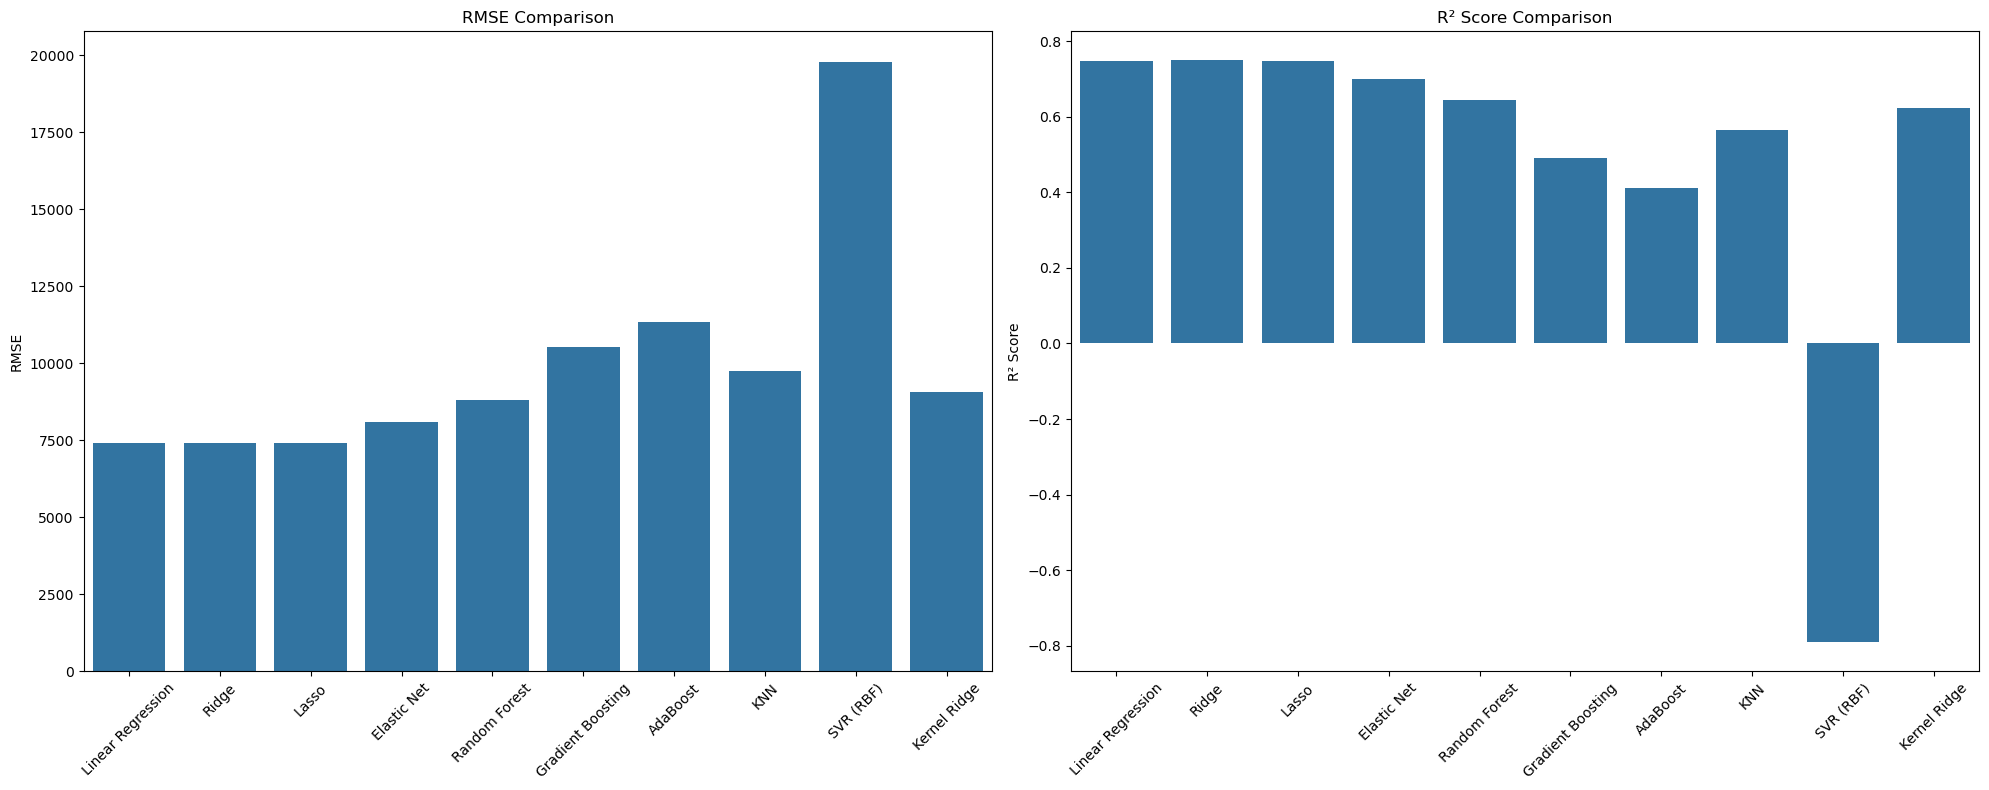

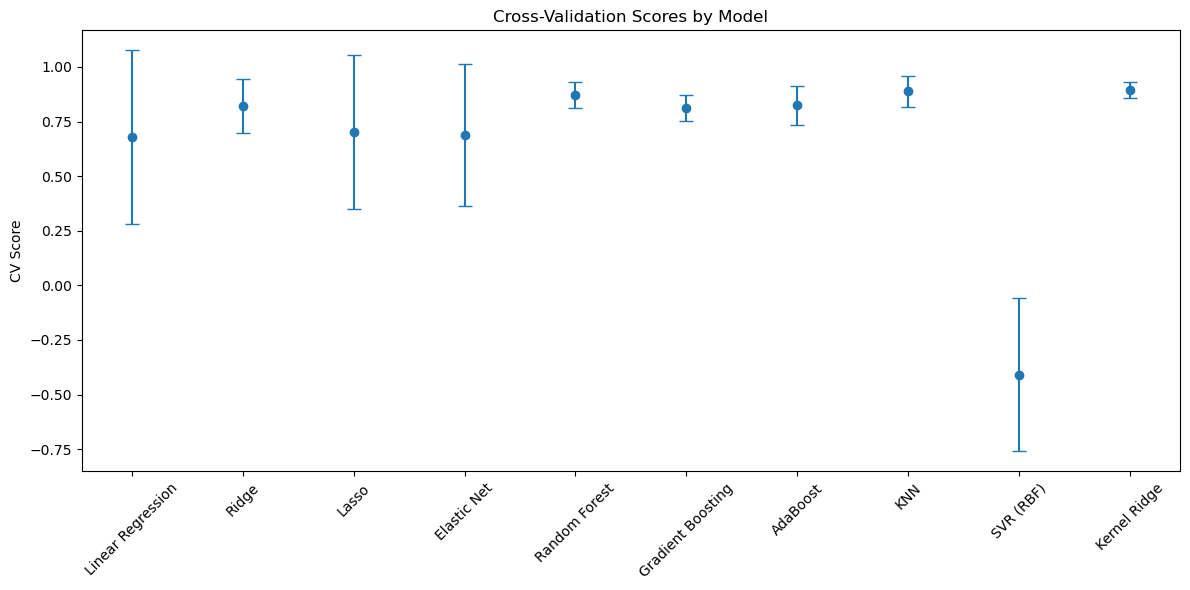

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_training_data(df):
    # Aggregate by region with additional variables
    df_agg = df.groupby(['Year', 'region']).agg({
        'Precipitation_avg': 'first',
        'Min_temp_avg': 'first', 
        'Avg_temp': 'first',
        'Total_Land_Area': 'sum',
        'state_park_land_coverage': 'mean',
        'state_park_rank': 'mean',
        'Lyme_cases': 'sum'
    }).reset_index()
    
    X = df_agg[['Min_temp_avg', 'Avg_temp', 'Precipitation_avg', 
                'Total_Land_Area', 'state_park_land_coverage', 'state_park_rank']]
    y = df_agg['Lyme_cases']
    
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    return X, y, imputer

def prepare_future_data(future_df, imputer):
    # Pivot temperature and precipitation data
    future_wide = future_df.pivot(index='region', 
                                columns='Indicator', 
                                values='value')
    
    # Add the static variables
    future_wide['Total_Land_Area'] = future_df.groupby('region')['Total_Land_Area'].first()
    future_wide['state_park_land_coverage'] = future_df.groupby('region')['state_park_land_coverage'].first()
    future_wide['state_park_rank'] = future_df.groupby('region')['state_park_rank'].first()
    
    X_future = future_wide[['Min_temp', 'Avg_temp', 'Precipitation_avg', 
                           'Total_Land_Area', 'state_park_land_coverage', 'state_park_rank']].values
    return X_future, future_wide.index

def train_and_evaluate_expanded_models(X, y):
   # Split the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
   # Scale the features
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)
   
   # Initialize expanded set of models
   models = {
       'Linear Regression': LinearRegression(),
       'Ridge': Ridge(alpha=0.1),
       'Lasso': Lasso(alpha=0.1),
       'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
       'Random Forest': RandomForestRegressor(n_estimators=200, min_samples_leaf=2),
       'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1),
       'AdaBoost': AdaBoostRegressor(n_estimators=200),
       'KNN': KNeighborsRegressor(n_neighbors=3),
       'SVR (RBF)': SVR(kernel='rbf', C=10),
       'Kernel Ridge': KernelRidge(kernel='rbf', alpha=0.1)
   }
   
   # Train and evaluate models
   results = {}
   trained_models = {}
   
   for name, model in models.items():
       try:
           # Train model
           model.fit(X_train_scaled, y_train)
           
           # Make predictions
           y_pred = model.predict(X_test_scaled)
           
           # Calculate metrics
           mse = mean_squared_error(y_test, y_pred)
           rmse = np.sqrt(mse)
           r2 = r2_score(y_test, y_pred)
           
           # Perform cross-validation
           cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
           
           results[name] = {
               'RMSE': rmse,
               'R2': r2,
               'CV_mean': cv_scores.mean(),
               'CV_std': cv_scores.std()
           }
           trained_models[name] = model
           
       except Exception as e:
           print(f"Error training {name}: {str(e)}")
   
   return results, trained_models, scaler

def plot_expanded_model_comparison(results):
   # Create figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
   
   # Prepare data for plotting
   models = list(results.keys())
   rmse_scores = [results[model]['RMSE'] for model in models]
   r2_scores = [results[model]['R2'] for model in models]
   
   # Plot RMSE comparison
   sns.barplot(x=models, y=rmse_scores, ax=ax1)
   ax1.set_title('RMSE Comparison')
   ax1.set_ylabel('RMSE')
   ax1.tick_params(axis='x', rotation=45)
   
   # Plot R² comparison
   sns.barplot(x=models, y=r2_scores, ax=ax2)
   ax2.set_title('R² Score Comparison')
   ax2.set_ylabel('R² Score')
   ax2.tick_params(axis='x', rotation=45)
   
   plt.tight_layout()
   return fig

def plot_cross_validation_results(results):
   fig, ax = plt.subplots(figsize=(12, 6))
   
   models = list(results.keys())
   cv_means = [results[model]['CV_mean'] for model in models]
   cv_stds = [results[model]['CV_std'] for model in models]
   
   # Plot CV scores with error bars
   ax.errorbar(models, cv_means, yerr=cv_stds, fmt='o', capsize=5)
   ax.set_title('Cross-Validation Scores by Model')
   ax.set_ylabel('CV Score')
   plt.xticks(rotation=45)
   plt.tight_layout()
   
   return fig

# Main execution
if __name__ == "__main__":
   # Load and prepare data
   hist_df = pd.read_csv('../data/clean_data/data.csv')
   future_df = pd.read_csv('../data/clean_data/2050inputs.csv')
   
   X, y, imputer = prepare_training_data(hist_df)
   
   # Train and evaluate expanded set of models
   results, trained_models, scaler = train_and_evaluate_expanded_models(X, y)
   
   # Print detailed results
   print("\nModel Performance Metrics:")
   for model_name, metrics in results.items():
       print(f"\n{model_name}:")
       for metric_name, value in metrics.items():
           print(f"{metric_name}: {value:.4f}")
   
   # Plot comparisons
   comparison_fig = plot_expanded_model_comparison(results)
   cv_fig = plot_cross_validation_results(results)
   
   # Prepare and predict with 2050 data
   future_X, future_regions = prepare_future_data(future_df, imputer)
   future_X_scaled = scaler.transform(future_X)

# Make predictions for 2050
print("\nPredicted Lyme Disease Cases for 2050 by Region:")
for model_name, model in trained_models.items():
    predictions = model.predict(future_X_scaled)
    print(f"\n{model_name} predictions:")
    for region, pred in zip(future_regions, predictions):
        print(f"{region}: {max(0, int(pred))} cases")